In [1]:
!wget https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/True.csv

--2025-07-07 19:23:12--  https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/True.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23241283 (22M) [text/plain]
Saving to: ‘True.csv.1’

True.csv.1          100%[===================>]  22,16M  47,4MB/s    in 0,5s    

2025-07-07 19:23:13 (47,4 MB/s) - ‘True.csv.1’ saved [23241283/23241283]



In [2]:
!wget https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/Fake.csv

--2025-07-07 19:23:13--  https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/Fake.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25306716 (24M) [text/plain]
Saving to: ‘Fake.csv.1’

Fake.csv.1          100%[===================>]  24,13M  47,2MB/s    in 0,5s    

2025-07-07 19:23:14 (47,2 MB/s) - ‘Fake.csv.1’ saved [25306716/25306716]



label
0    4000
1    4000
Name: count, dtype: int64


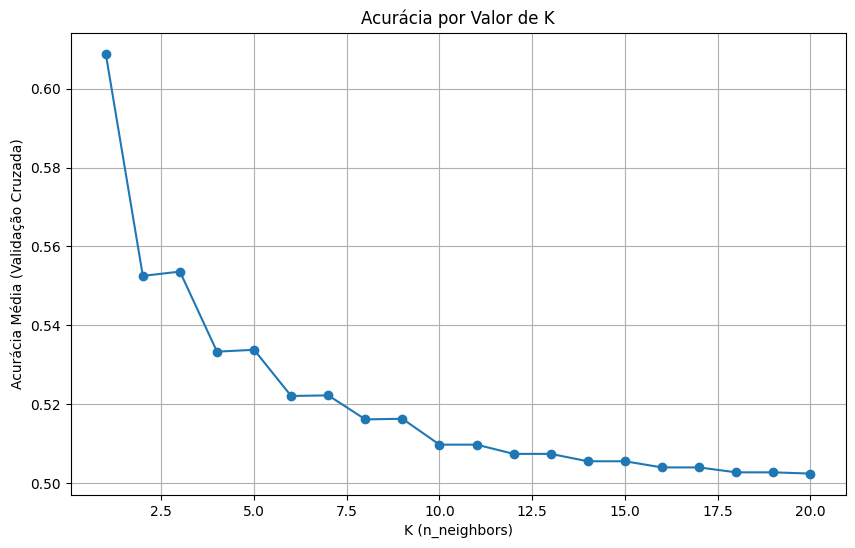

Melhor valor de K: 1
Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.5740    0.9838    0.7250       800
           1     0.9432    0.2700    0.4198       800

    accuracy                         0.6269      1600
   macro avg     0.7586    0.6269    0.5724      1600
weighted avg     0.7586    0.6269    0.5724      1600



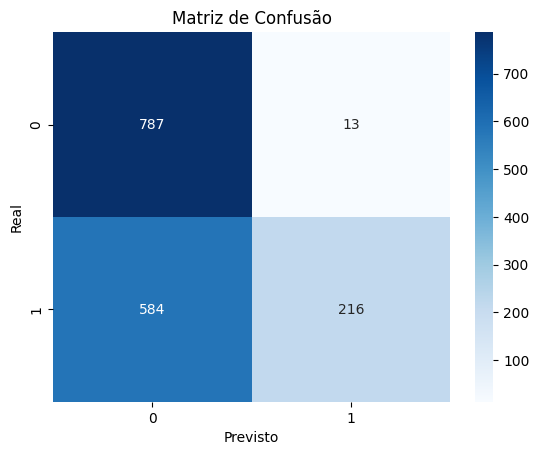

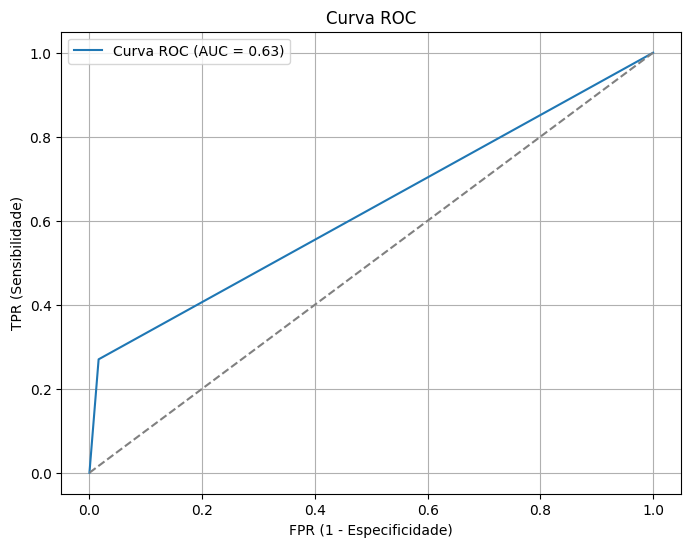

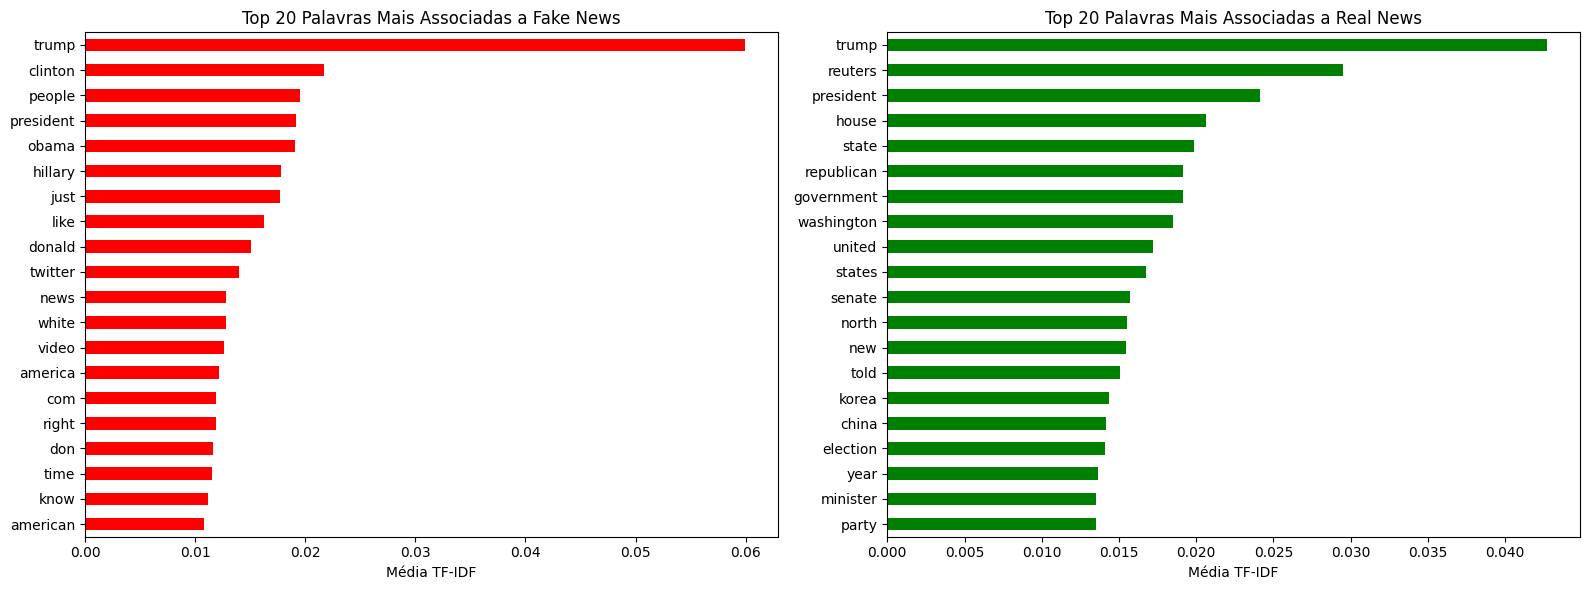

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

column_names = ["title", "text", "subject", "date"]

fake_df = pd.read_csv("Fake.csv", names=column_names)
true_df = pd.read_csv("True.csv", names=column_names)

fake_df["label"] = 0 
true_df["label"] = 1 

n_samples_per_class = 4000
fake_sample = fake_df.sample(n=n_samples_per_class, random_state=42)
true_sample = true_df.sample(n=n_samples_per_class, random_state=42)

data = pd.concat([fake_sample, true_sample], ignore_index=True)

print(data["label"].value_counts())  

texts = data["text"]
labels = data["label"]

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(texts)
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

k_values = list(range(1, 21))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    accuracies.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("K (n_neighbors)")
plt.ylabel("Acurácia Média (Validação Cruzada)")
plt.title("Acurácia por Valor de K")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Melhor valor de K: {best_k}")

final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

y_scores = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Sensibilidade)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

X_array = X.toarray()

tfidf_df = pd.DataFrame(X_array, columns=vectorizer.get_feature_names_out())
tfidf_df["label"] = labels.values

fake_means = tfidf_df[tfidf_df["label"] == 0].drop(columns="label").mean()
real_means = tfidf_df[tfidf_df["label"] == 1].drop(columns="label").mean()

top_fake = fake_means.sort_values(ascending=False).head(20)

top_real = real_means.sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
top_fake.plot(kind="barh", color="red")
plt.title("Top 20 Palavras Mais Associadas a Fake News")
plt.xlabel("Média TF-IDF")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
top_real.plot(kind="barh", color="green")
plt.title("Top 20 Palavras Mais Associadas a Real News")
plt.xlabel("Média TF-IDF")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
